# Car Price prediction 2

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по его характеристикам

In [2]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import torch
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [9]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

In [12]:
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

#### Далее проведём обработку данных и приведём в нормальный вид

In [14]:
data.bodyType.unique()

array(['универсал 5 дв.', 'купе', 'седан', 'внедорожник 5 дв.', 'родстер',
       'лифтбек', 'хэтчбек 3 дв.', 'хэтчбек 5 дв.', 'купе-хардтоп',
       'внедорожник 3 дв.', 'минивэн', 'кабриолет',
       'пикап двойная кабина', 'внедорожник открытый', 'компактвэн',
       'седан 2 дв.', 'лимузин'], dtype=object)

In [15]:
data.bodyType = data.drop(data[data.bodyType == 'внедорожник открытый'].index)
data.bodyType = data.drop(data[data.bodyType == 'внедорожник 3 дв.'].index)
data['bodyType'] = data['bodyType'].fillna('внедорожник 5 дв.')

data.bodyType = data.drop(data[data.bodyType == 'хэтчбек 3 дв.'].index)
data['bodyType'] = data['bodyType'].fillna('хэтчбек 5 дв.')

data.bodyType = data.drop(data[data.bodyType == 'купе-хардтоп'].index)
data['bodyType'] = data['bodyType'].fillna('купе')

data.bodyType = data.drop(data[data.bodyType == 'седан-хардтоп'].index)
data.bodyType = data.drop(data[data.bodyType == 'седан 2 дв.'].index)
data['bodyType'] = data['bodyType'].fillna('седан')

data.bodyType = data.drop(data[data.bodyType == 'пикап полуторная кабина'].index)
data.bodyType = data.drop(data[data.bodyType == 'пикап одинарная кабина'].index)
data['bodyType'] = data['bodyType'].fillna('пикап двойная кабина')

In [16]:
data['bodyType'] = [str(x).lower().replace('.', '') for x in data['bodyType']]
data['bodyType'] = [str(x).lower().replace('дв', '') for x in data['bodyType']]
data['bodyType'] = [str(x).lower().replace('5', '') for x in data['bodyType']]
data['bodyType'] = [str(x).lower().replace('кабина', '') for x in data['bodyType']]
data['bodyType'] = [str(x).lower().replace('ойная', '') for x in data['bodyType']]
data['bodyType'] = [str(x).lower().replace(' ', '') for x in data['bodyType']]

In [17]:
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: '2.0 LTR' if x == 'undefined LTR' else x)
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: str(x).replace('LTR', ''))

In [18]:
data['enginePower'] = data['enginePower'].apply(lambda x: x.replace(' N12', ''))

In [19]:
data['Владельцы'] = [str(x).lower().replace('или', '') for x in data['Владельцы']]
data['Владельцы'] = [str(x).lower().replace('более', '') for x in data['Владельцы']]
data['Владельцы'] = [str(x).lower().replace('владелец', '') for x in data['Владельцы']]
data['Владельцы'] = [str(x).lower().replace('владельца', '') for x in data['Владельцы']]
data['Владельцы'] = [str(x).lower().replace(' ', '') for x in data['Владельцы']]
data['Владельцы'] = [str(x).replace('1\xa0', '1') for x in data['Владельцы']]
data['Владельцы'] = [str(x).replace('2\xa0', '2') for x in data['Владельцы']]
data['Владельцы'] = data['Владельцы'].apply(lambda x: '1' if x == 'nan' else x)
data['Владельцы'] = data['Владельцы'].astype('float64')

In [20]:
data.price = data.price.astype('float64')

In [21]:
data_drop = ['name', 'modelDate', 'vehicleConfiguration', 'Владение']
data.drop(columns=data_drop, inplace=True)

Удалим не нужные колонки

In [22]:
data.duplicated().sum()

0

Дубликатов нет

#### Это всё было сделано по подобию предыдущего проекта про предсказание цены авто.

### Построим наивную модель, чтобы знать, от какого результата отталкиваться

In [23]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [24]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


Точность наивной модели: 19.88%

# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

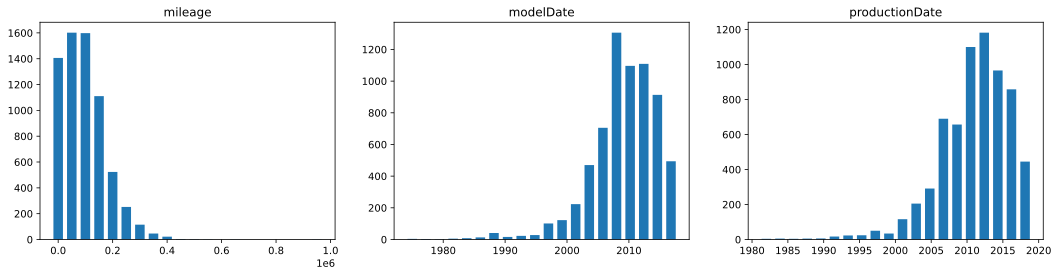

In [25]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

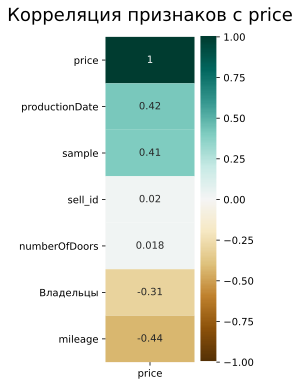

In [26]:
# Посмотрим на корреляцию признаков с целевой переменной price
plt.figure(figsize=(2, 6))
heatmap = sns.heatmap(data.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Корреляция признаков с price', fontdict={'fontsize':18}, pad=16);

Всё хорошо, сильно скоррелированных признаков нет

In [27]:
# Используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль']

# Используем все числовые признаки
numerical_features = ['mileage', 'productionDate']

### Сделаем обработку и завернём в одну большую функцию

In [101]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    
    # убираем не нужные для модели признаки
    df_output.drop('sell_id', axis = 1, inplace=True)
    df_output.drop(['description'], axis=1, inplace=True)
    
    #
    df_output['model_info'] = df_output['model_info'].fillna('unknown')
    df_output['model_info'] = df_output['model_info'].apply(lambda x: (x.split(' ')[0]).lower())
    
    #
    df_output.ПТС=df_output.ПТС.fillna('Дубликат')
    df_output.engineDisplacement=df_output.engineDisplacement.fillna(2.0)
    df_output.engineDisplacement=df_output.engineDisplacement.astype('float64')
    df_output.enginePower=df_output.enginePower.astype('float64')
    df_output.Владельцы=df_output.Владельцы.fillna(0.0)
    df_output.Владельцы=df_output.Владельцы.astype('float64')
    df_output.price=df_output.price.astype('float64')
    
     #
    df_output['years_old'] = 2021 - df_output['productionDate']
    df_output['car_rarity']=(df_output.years_old >= 50).astype('float64')
    df_output['car_new']=(df_output.years_old <= 3).astype('float64')
    df_output['car_econom']=(df_output.engineDisplacement <= 1.5).astype('float64')
    df_output['car_premium']=(df_output.engineDisplacement >= 3.0).astype('float64')
    df_output['disp_power'] = df_output.engineDisplacement * df_output.enginePower
    df_output['mil_prod'] = df_output.mileage * df_output.productionDate
    df_output['disp_prod'] = df_output.engineDisplacement * df_output.productionDate
    df_output['power_prod'] = df_output.enginePower * df_output.productionDate
    
    #
    df_output['new_car_new'] = df_output.mileage.apply(lambda x: 1 if x == 0 else 0)
    
    # Сделаем логарифмирование, уменьшив выбросы, если таковые будут иметься.
    df_output['productionDate'] = np.log(df_output['productionDate'] + 1)
    df_output['years_old'] = np.log(df_output['years_old'] + 1)
    df_output['mileage'] = np.log(df_output['mileage'] + 1)
    
    new_col = ['power_prod','disp_prod','mil_prod','disp_power','years_old']
    
    #
    for col in ['color','brand','bodyType','engineDisplacement','Владельцы','model_info',
                'enginePower','fuelType','numberOfDoors','productionDate','Привод']:
        col_means = df_output.groupby([col])['price'].mean().to_dict()
        df_output[col + '_' + 'price'] = df_output[col].apply(lambda x: col_means[x])
        
    for col in ['color','brand','bodyType','engineDisplacement','Владельцы','model_info',
                'enginePower','fuelType','numberOfDoors','productionDate','Привод']:
        col_means = df_output.groupby([col])['price'].std().to_dict()
        df_output[col + '_' + 'prices'] = df_output[col].apply(lambda x: col_means[x])    
    
    
    for col in ['color','brand','bodyType','engineDisplacement','Владельцы','model_info',
                'enginePower','fuelType','numberOfDoors','productionDate','Привод']:
        col_means = df_output.groupby([col])['mileage'].mean().to_dict()
        df_output[col + '_' + 'mileage'] = df_output[col].apply(lambda x: col_means[x])
        
    for col in ['color','brand','bodyType','engineDisplacement','Владельцы','model_info',
                'enginePower','fuelType','numberOfDoors','productionDate','Привод']:
        col_means = df_output.groupby([col])['mileage'].std().to_dict()
        df_output[col + '_' + 'mileages'] = df_output[col].apply(lambda x: col_means[x])    
        
    for col in ['color','brand','bodyType','engineDisplacement','Владельцы','model_info',
                'enginePower','fuelType','numberOfDoors','productionDate','Привод']:
        col_means = df_output.groupby([col])['productionDate'].mean().to_dict()
        df_output[col + '_' + 'productionDate'] = df_output[col].apply(lambda x: col_means[x])
        
    for col in ['color','brand','bodyType','engineDisplacement','Владельцы','model_info',
                'enginePower','fuelType','numberOfDoors','productionDate','Привод']:
        col_means = df_output.groupby([col])['productionDate'].std().to_dict()
        df_output[col + '_' + 'productionDates'] = df_output[col].apply(lambda x: col_means[x])    
    
    #
    df_output['km_pro_year'] = (df_output['mileage']/(2021 - df_output['productionDate'])).astype('float64')
    #
    df_output['mileage_per_age'] = (df_output.mileage / df_output.years_old).astype('float64')

    
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
        

    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
       
    for column in new_col:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    for column in df_output:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    
    
    # ################### Clean #################################################### 
    
    
    return df_output

In [102]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,mileage,productionDate,sample,price,years_old,car_rarity,car_new,car_econom,car_premium,disp_power,...,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
1765,0.857928,0.843362,1,1200000.0,0.462756,0.0,0.0,0.0,0.0,0.058643,...,0,0,1,0,1,0,1,0,1,0
2323,0.855429,0.791045,1,1500000.0,0.537244,0.0,0.0,0.0,1.0,0.169030,...,0,1,0,0,1,0,0,1,1,0
6686,0.820622,0.817210,1,1990000.0,0.502073,0.0,0.0,0.0,1.0,0.159065,...,0,0,1,0,1,0,0,1,1,0
7254,0.838424,0.764868,1,930000.0,0.569059,0.0,0.0,0.0,1.0,0.201227,...,0,1,0,0,1,0,0,1,1,0
1311,0.869323,0.660027,0,0.0,0.672591,0.0,0.0,0.0,1.0,0.151399,...,0,0,1,0,1,0,0,1,1,0
7090,0.881070,0.764868,1,535000.0,0.569059,0.0,0.0,0.0,0.0,0.040756,...,0,0,1,0,1,1,0,0,1,0
3369,0.718565,0.973926,1,5750000.0,0.135348,0.0,1.0,0.0,1.0,0.162131,...,1,0,0,0,1,0,0,1,1,0
7045,0.768599,0.712473,1,990000.0,0.624823,0.0,0.0,0.0,0.0,0.079085,...,0,1,0,0,1,0,0,1,1,0
5294,0.817978,0.791045,1,790000.0,0.537244,0.0,0.0,0.0,0.0,0.061709,...,0,0,1,0,1,0,0,1,1,0
5507,0.886328,0.633784,1,400000.0,0.694135,0.0,0.0,0.0,1.0,0.138367,...,1,0,0,0,1,1,0,0,1,0


In [103]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

# Model: ML

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [32]:
cat = CatBoostRegressor(iterations = 500,
                          learning_rate = 0.2,
                          random_seed = 42,
                          eval_metric='MAPE',
                          od_wait=500
                          #task_type='GPU',
                         )
cat.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )
test_predict_catboost = np.exp(cat.predict(X_test))
predict_submission = np.exp(cat.predict(X_sub))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

0:	learn: 0.0360567	test: 0.0360132	best: 0.0360132 (0)	total: 60.4ms	remaining: 30.1s
100:	learn: 0.0075843	test: 0.0081398	best: 0.0081289 (92)	total: 812ms	remaining: 3.21s
200:	learn: 0.0065410	test: 0.0077868	best: 0.0077868 (200)	total: 1.56s	remaining: 2.33s
300:	learn: 0.0058839	test: 0.0076241	best: 0.0076238 (288)	total: 2.31s	remaining: 1.53s
400:	learn: 0.0053964	test: 0.0075293	best: 0.0075287 (397)	total: 3.35s	remaining: 828ms
499:	learn: 0.0049699	test: 0.0074778	best: 0.0074680 (495)	total: 4.1s	remaining: 0us

bestTest = 0.007467985128
bestIteration = 495

Shrink model to first 496 iterations.
TEST mape: 10.54%


Довольно неплохой результат в 10.54%

In [33]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission_cat.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1099427284,5.800194e+05
1,1096405886,2.989807e+06
2,1100195294,6.237662e+05
3,1099827282,5.094817e+05
4,1100076198,2.781987e+06
5,1090159352,3.260318e+06
6,1098987386,1.603612e+06
7,1098639040,1.484655e+06
8,1099933039,1.086239e+06
9,1099565572,5.120145e+05


In [34]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=3000)

xg_reg.fit(X_train, np.log(y_train))
xg_red_pred = np.exp(xg_reg.predict(X_test))
predict_submission_1 = np.exp(xg_reg.predict(X_sub))
print(f"Точность модели по метрике MAPE: {(mape(y_test, xg_red_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 11.19%


Немного хуже...11.19%

In [35]:
sample_submission['price'] = predict_submission_1
sample_submission.to_csv('submission_xgb.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1099427284,4.551569e+05
1,1096405886,2.993146e+06
2,1100195294,6.248484e+05
3,1099827282,4.978245e+05
4,1100076198,2.732484e+06
5,1090159352,3.338224e+06
6,1098987386,1.571712e+06
7,1098639040,1.518648e+06
8,1099933039,1.052751e+06
9,1099565572,4.901990e+05


In [36]:
clf = RandomForestRegressor(n_estimators=3000, max_depth=None, min_samples_split=4, random_state=42)
#
clf.fit(X_train, np.log(y_train)).score(X_test, y_test)
clf_pred = np.exp(clf.predict(X_test))
predict_submission_clf = np.exp(clf.predict(X_sub))
print(f"Точность модели по метрике MAPE: {(mape(y_test, clf_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 11.50%


Точность модели: 11.50%

Забавно, но идём по нарастанию ошибки... Посмотрим, что покажет стэкинг.

In [37]:
from sklearn.ensemble import (RandomForestRegressor,
                              GradientBoostingRegressor, StackingRegressor)

estimators = [
              ('catboost', CatBoostRegressor(iterations = 500,
                       random_seed = RANDOM_SEED,
                       eval_metric='MAPE',
                       silent=True,
                       learning_rate=0.2,depth=10,
                       l2_leaf_reg=5)), 
              ('xgboost', xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                         learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=3000, silent=1)),
              ('forest', RandomForestRegressor(n_estimators=3000, max_depth=None,min_samples_split=4,
                                                random_state=42))]
              

stack = StackingRegressor(estimators=estimators,
                          n_jobs=-1)#,
                          #final_estimator=xg_reg)

stack.fit(X_train, np.log(y_train)).score(X_test, y_test)
stack_pred = np.exp(stack.predict(X_test))
predict_submission_stack = np.exp(stack.predict(X_sub))
print(f"Точность модели по метрике MAPE: {(mape(y_test, stack_pred))*100:0.2f}%")                          

Точность модели по метрике MAPE: 10.92%


Усреднив три модели получили точность модели: 10.92%
Не так плохо, но Catboost чуть лучше.

In [38]:
sample_submission['price'] = predict_submission_stack
sample_submission.to_csv('submission_stack.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1099427284,4.999243e+05
1,1096405886,2.845113e+06
2,1100195294,6.438936e+05
3,1099827282,5.003573e+05
4,1100076198,2.741585e+06
5,1090159352,3.206349e+06
6,1098987386,1.567006e+06
7,1098639040,1.480711e+06
8,1099933039,1.077261e+06
9,1099565572,4.989705e+05


# Model: Tabular NN

Построим обычную сеть:

## Simple Dense NN

In [39]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               233984    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 366,593
Trainable params: 366,081
Non-trainable params: 512
________________________________________________

In [41]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [42]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

### Fit

In [43]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0
                   )

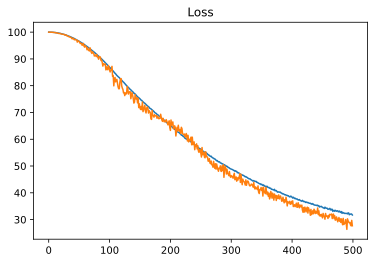

In [44]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [45]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [46]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 27.68%


Точность модели: 27.68%
Плоховато... хотя использовал батчнормализацию... Судя по графику, можно попробовать увеличить кол-во эпох...

In [47]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

# Model: NLP + Multiple Inputs

### Почистим текст в description. Чтобы модель лучше с ней работала

In [48]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords, words
from nltk.tokenize import RegexpTokenizer

def process(input_text):
    tokenizer = RegexpTokenizer(r'\w+')
    stemmer = SnowballStemmer('russian')
 
    stop_words = stopwords.words('russian')
    
    tokens = tokenizer.tokenize(input_text.lower())

    tokens = [x for x in tokens if not x in stop_words]
     
    tokens_stemmed = [stemmer.stem(x) for x in tokens]

    return tokens_stemmed

data['description'] = data.description.apply(process)

Применил стоп-слова. Использовал стеммер, т.к. описание авто владельцем - это субъективная точка зрения и точность в словах не имеет смысла.

In [49]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

### Tokenizer

In [50]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 552 ms, sys: 2.96 ms, total: 555 ms
Wall time: 554 ms


In [51]:
tokenize.word_index

{'автомобил': 1,
 'систем': 2,
 'пробег': 3,
 'задн': 4,
 'салон': 5,
 'сиден': 6,
 'состоян': 7,
 'передн': 8,
 'машин': 9,
 'диск': 10,
 '2': 11,
 'комплект': 12,
 'дилер': 13,
 'официальн': 14,
 'год': 15,
 'нов': 16,
 'ваш': 17,
 'фар': 18,
 'авт': 19,
 'рул': 20,
 'безопасн': 21,
 'гарант': 22,
 'пакет': 23,
 'колес': 24,
 'комплектац': 25,
 'контрол': 26,
 'птс': 27,
 'лет': 28,
 'bmw': 29,
 '000': 30,
 'проверк': 31,
 'зерка': 32,
 'покупк': 33,
 'продаж': 34,
 'водител': 35,
 'полн': 36,
 'отличн': 37,
 'автомоб': 38,
 'техническ': 39,
 'шин': 40,
 'датчик': 41,
 'прода': 42,
 'пассажир': 43,
 '1': 44,
 'двигател': 45,
 'резин': 46,
 'услов': 47,
 'ключ': 48,
 'юридическ': 49,
 'кред': 50,
 'люб': 51,
 'подушк': 52,
 '6': 53,
 'обслуживан': 54,
 'км': 55,
 '3': 56,
 'торг': 57,
 'оригина': 58,
 'дополнительн': 59,
 'обогр': 60,
 'двер': 61,
 'масл': 62,
 'черн': 63,
 'стекл': 64,
 'рулев': 65,
 'возможн': 66,
 'электропривод': 67,
 'оригинальн': 68,
 'наш': 69,
 'климат': 70,
 

In [52]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

In [53]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 617 ms, sys: 1.95 ms, total: 619 ms
Wall time: 618 ms


In [54]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

['автомобил', 'провер', '110', 'пункт', 'автокред', 'специальн', 'ставк', '13', '7', 'ауд', 'центр', 'север', 'официальн', 'дилер', 'aud', 'входя', 'групп', 'компан', 'рольф', 'явля', 'одн', 'крупн', 'дилер', 'европ', 'предлага', 'ряд', 'услуг', 'покупк', 'продаж', 'автомобил', 'пробег', 'протяжен', 'мног', 'лет', 'наш', 'дилерск', 'центр', 'явля', 'лидер', 'продаж', 'автомобил', 'пробег', 'сред', 'дилер', 'aud', 'росс', 'предоставля', 'клиент', 'сам', 'больш', 'выбор', 'автомобил', 'пробег', 'aud', 'друг', 'марок', 'кажд', 'автомобил', 'проход', 'тщательн', 'диагностик', 'подготовк', 'гарантирова', 'наход', 'отличн', 'состоян', 'убед', 'правильн', 'выбор', 'возможн', 'пройт', 'тест', 'драйв', 'ознакомительн', 'поездк', 'интерес', 'автомобил', 'сможет', 'ознаком', 'автомобил', 'выход', 'дом', 'наш', 'менеджер', 'проведет', 'onlin', 'презентац', 'видеозвонк', 'покажет', 'выбра', 'автомобил', 'такж', 'ауд', 'центр', 'север', 'представля', 'уникальн', 'предложен', 'кредитован', 'автомобил

### RNN NLP

In [57]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.BatchNormalization())
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(32, activation="relu"))
model_nlp.add(L.BatchNormalization())
model_nlp.add(L.Dropout(0.25))

### MLP

In [58]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(64, activation="relu"))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(32, activation="relu"))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [59]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [60]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_8_input (InputLayer)      [(None, 456)]        0                                            
__________________________________________________________________________________________________
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 512)          233984      dense_8_input[0][0]              
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 256, 256)     5656576     seq_description[0][0]            
_______________________________________________________________________________________

### Fit

In [61]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [62]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [63]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 4s 318ms/step - loss: 99.9996 - MAPE: 99.9996 - val_loss: 100.0012 - val_MAPE: 100.0012
Epoch 2/500
12/12 [==============================] - 3s 251ms/step - loss: 99.9967 - MAPE: 99.9967 - val_loss: 99.9936 - val_MAPE: 99.9936
Epoch 3/500
12/12 [==============================] - 3s 253ms/step - loss: 99.9848 - MAPE: 99.9848 - val_loss: 99.9095 - val_MAPE: 99.9095
Epoch 4/500
12/12 [==============================] - 3s 251ms/step - loss: 99.9511 - MAPE: 99.9511 - val_loss: 99.8326 - val_MAPE: 99.8326
Epoch 5/500
12/12 [==============================] - 3s 251ms/step - loss: 99.8655 - MAPE: 99.8655 - val_loss: 99.7640 - val_MAPE: 99.7640
Epoch 6/500
12/12 [==============================] - 3s 254ms/step - loss: 99.6922 - MAPE: 99.6922 - val_loss: 99.7819 - val_MAPE: 99.7819
Epoch 7/500
12/12 [==============================] - 3s 246ms/step - loss: 99.3972 - MAPE: 99.3972 - val_loss: 99.7328 - val_MAPE: 99.7328
Epoch 8/500
12/12 [======

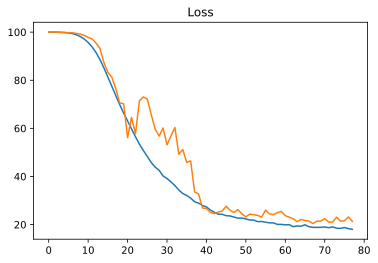

In [64]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [65]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [66]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 21.35%


Добавил по одному слою и добавил батчнормализацию. Но результат прям не очень - 21.35%, но лучше, чем у простой модели. Возможно требуются более тонкие настройки нейросети или лучше обработать текст.

In [67]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

# Model: Добавляем картинки

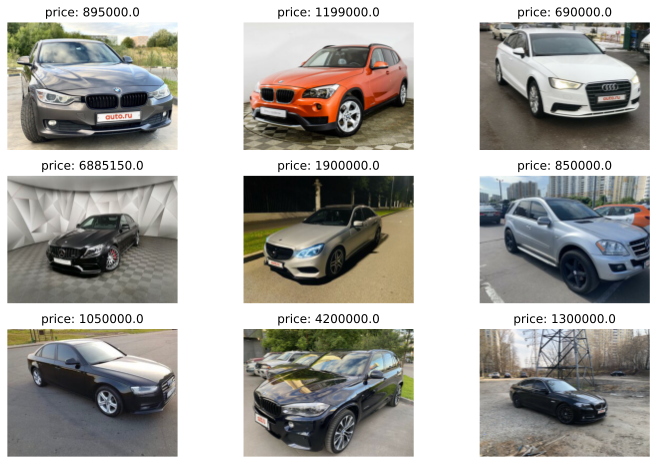

In [68]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [69]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

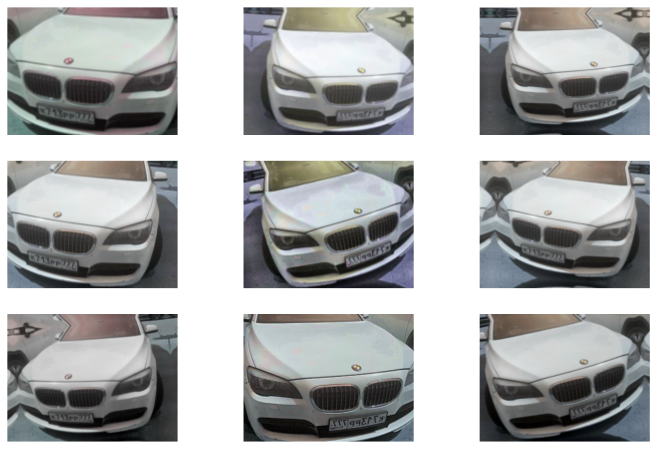

In [70]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [74]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
    print('')
    return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [75]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [76]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, text_train_sequences, y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, text_train_sequences, y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, text_train_sequences, y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

ValueError: Dimensions 1003 and 5679 are not compatible

Погуглив, при такой ошибке советы дают сделать отладку кода, но я не знаю как... а дедлайн поджимает... Надеюсь в обратной связи получить решение данной ошибки. В связи с этим, добавить картинки в общую модель не получится. Если честно, то я не верю в улучшение модели с помощью картинок в этом проекте, т.к. мы предсказываем цену авто, а не его модель.

#### В связи с этим, ячейки с кодом, которые выдают ошибку из-за ошибки, которая у меня возникла я закоментирую.

### Строим сверточную сеть для анализа изображений без "головы"

In [77]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [78]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [79]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [80]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [81]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [82]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [88]:
# history = model.fit(train_dataset.batch(30),
#                     epochs=100,
#                     validation_data = test_dataset.batch(30),
#                     callbacks=callbacks_list
#                    )

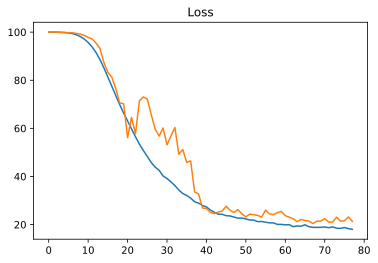

In [84]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [89]:
# model.load_weights('../working/best_model.hdf5')
# model.save('../working/nn_final.hdf5')

In [90]:
# test_predict_nn3 = model.predict(test_dataset.batch(30))
# print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

In [91]:
# sub_predict_nn3 = model.predict(sub_dataset.batch(30))
# sample_submission['price'] = sub_predict_nn3[:,0]
# sample_submission.to_csv('nn3_submission.csv', index=False)

# Blend

In [92]:
blend_predict = (test_predict_catboost + test_predict_nn2[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 13.90%


Точность модели: 13.90%

#### Блендинг ML и DL ничего позитивного не дал...

# Model Bonus: проброс признака

In [105]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(128, activation="relu"))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dropout(0.5))

In [107]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [108]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [109]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_22_input (InputLayer)     [(None, 456)]        0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 512)          233984      dense_22_input[0][0]             
__________________________________________________________________________________________________
dropout_22 (Dropout)            (None, 512)          0           dense_22[0][0]                   
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 256)          131328      dropout_22[0][0]                 
_______________________________________________________________________________________

In [110]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [113]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 23ms/step - loss: 99.9991 - MAPE: 99.9991 - val_loss: 99.9952 - val_MAPE: 99.9952
Epoch 2/500
12/12 [==============================] - 0s 11ms/step - loss: 99.9869 - MAPE: 99.9869 - val_loss: 99.9549 - val_MAPE: 99.9549
Epoch 3/500
12/12 [==============================] - 0s 10ms/step - loss: 99.9395 - MAPE: 99.9395 - val_loss: 99.7413 - val_MAPE: 99.7413
Epoch 4/500
12/12 [==============================] - 0s 9ms/step - loss: 99.8213 - MAPE: 99.8213 - val_loss: 99.5596 - val_MAPE: 99.5596
Epoch 5/500
12/12 [==============================] - 0s 9ms/step - loss: 99.5821 - MAPE: 99.5821 - val_loss: 99.2902 - val_MAPE: 99.2902
Epoch 6/500
12/12 [==============================] - 0s 9ms/step - loss: 99.1536 - MAPE: 99.1536 - val_loss: 99.3898 - val_MAPE: 99.3898
Epoch 7/500
12/12 [==============================] - 0s 9ms/step - loss: 98.4624 - MAPE: 98.4624 - val_loss: 97.8887 - val_MAPE: 97.8887
Epoch 8/500
12/12 [===================

In [114]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 18.32%


Точность модели: 18.32%
Получилось что-то среднее между ML и DL...

In [116]:
# DATA_DIR_1 = '../input/dataset-x/'
# train_1 = pd.read_csv(DATA_DIR_1 + 'dataset.csv')

В слежующий раз попробую загрузить дополнительные (уже предобработанные под этот проект) данные из прошлого проекта, возможно результат будет лучше. Но пока так, как есть.

### Вывод: 
* ML справляется лучше NN, видимо из-за специфики данных. Но и может быть, потому что я плохо настроил нейросеть и поэтому результаты получились не очень.
* С изображениями возникла ошибка... поэтому код в этом месте не воспроизводим. Картинки не смогут помочь в улучшении модели, т.к. мы предсказываем цену, а не модель авто.
* Блендинг ML и NN не дал хорошего результата...
* Проброс признака тоже не оправдал ожиданий...
* Лучше всех справился Catboost! Видимо из-за того, что данных мало и много категориальных признаков. При добавлении данных картина возможно будет другая.
* Не знаю, но можно попробовать добавить полиноминальные признаки...может будет лучше...

In [ ]:
# 